# Westeros Introducing emissions: Adding emission bounds,  800 MtCO2

In the first part, the model chose not to base the power system on wind power as electricity from  wind turbines was more expensive than electricity produced from coal. However, now we introduce emissions to investigate the impact of climate policy. Now solar power is also in the model. Let's see what happens then.

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Westeros baseline scenario (``westeros_baseline.ipynb``) and solved it successfully

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

## Making a clone of the existing scenario 'baseline'

In [3]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="solar_power")
scen = base.clone(
    model,
    "emission_bound",
    "introducing an upper bound on emissions",
    keep_solution=False,
)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

## Introducing Emissions

In [5]:
# First we introduce the emission of CO2 and the emission category GHG
scen.add_set("emission", "CO2")
scen.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

# Last we add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4,
)
scen.add_par("emission_factor", emission_factor)

## Define a Bound on Emissions

The `"type_year": "cumulative"` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.

In [6]:
scen.add_par(
    "bound_emission", [country, "GHG", "all", "cumulative"], value=800.0, unit="MtCO2"
)

## Time to Solve the Model

In [7]:
scen.commit(comment="Introducing emissions and setting an upper bound")
scen.set_as_default()

In [8]:
scen.solve()

In [9]:
scen.var("OBJ")["lvl"]

171412.796875

## Plotting Results

In [10]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen)
prepare_plots(rep)

### Activity

How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

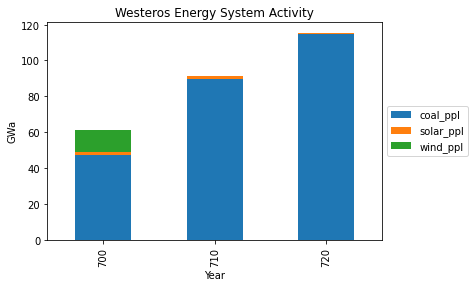

In [11]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "solar_ppl"])
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

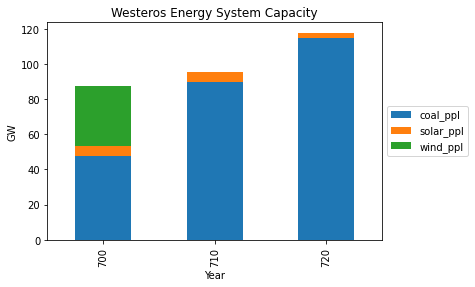

In [12]:
rep.get("plot capacity")

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution. They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of electricity), which is in fact the marginal cost of the most expensive generator.  

Notice the drop in the price in the period of 710? 

The share of the activity of the coal power plant is in the period of 710 higher then the share in the period of 700. With lower electricity costs of the coal power plant, this leads to reduced electricity costs. To stay within the emission bounds with an increased electricity demand, in the upcoming period of 720, the capacity of the wind turbines increases drastically, while the capacity of the coal power plants remains the same. This results in the increased electricity price.

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

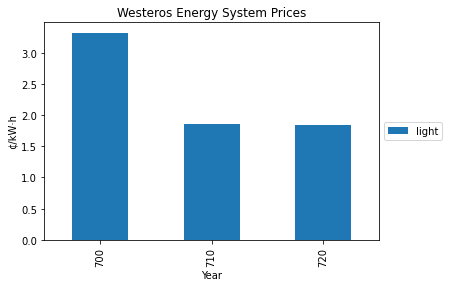

In [13]:
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

## Close the connection to the database

In [14]:
mp.close_db()

**ANALYSIS**

With lower emission bounds, more renewable energy gets included in the energy mix and we havae more renewables than coal. They have to be included for the system to meet the bounds. The prices for electricity in year 720 are lower than when only coal was used in 720. In this model, coal power still dominates in 720, even though the operational costs of wind and solar power plants are lower. This emission bound is still too high for significant changes in the energy mix to be made. Stricter emission bounds, stricter policies are needed for a renewable energy mix.